# Example notebook

In [26]:
%matplotlib inline
from skimage import transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import time
import torch.nn.functional as F
from torch.utils.data import DataLoader
from floortrans.models import get_model
from floortrans.loaders import FloorplanSVG, DictToTensor, Compose, RotateNTurns
from floortrans.plotting import segmentation_plot, polygons_to_image, draw_junction_from_dict, discrete_cmap
discrete_cmap()
from floortrans.post_prosessing import split_prediction, get_polygons, split_validation
from mpl_toolkits.axes_grid1 import AxesGrid

rot = RotateNTurns()
room_classes = ["Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"]
icon_classes = ["No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"]

data_folder = 'data/cubicasa5k/'
data_file = 'test.txt'
normal_set = FloorplanSVG(data_folder, data_file, format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)
data_iter = iter(data_loader)
# Setup Model
model = get_model('hg_furukawa_original', 51)

n_classes = 44
split = [21, 12, 11]
model.conv4_ = torch.nn.Conv2d(256, n_classes, bias=True, kernel_size=1)
model.upsample = torch.nn.ConvTranspose2d(n_classes, n_classes, kernel_size=4, stride=4)
# checkpoint = torch.load('model_best_val_loss_var.pkl')

# model.load_state_dict(checkpoint['model_state'])
# model.eval()
# model.cuda()
# print("Model loaded.")

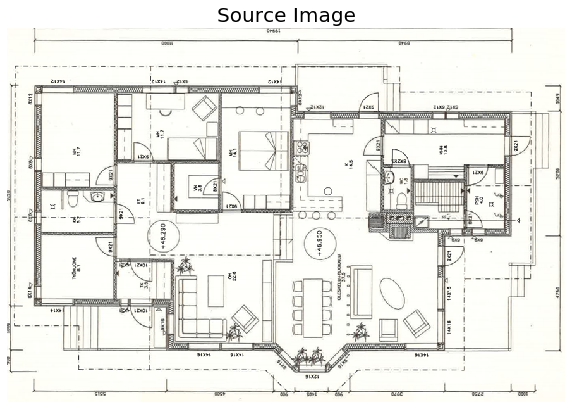

In [27]:
val = next(data_iter)
junctions = val['heatmaps']
folder = val['folder'][0]
image = val['image']#.cuda()
label = val['label']
np_img = np.moveaxis(image[0].cpu().data.numpy(), 0, -1) / 2 + 0.5
plt.figure(figsize=(10,10))
plt.title('Source Image', fontsize=20)
plt.axis('off')
plt.imshow(np_img)
plt.show()

## The SVG floorplan
If the floorplan includes two floors the other floor might not be visible, but it will be parsed never the less.

In [28]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url=data_folder+folder[1:]+"model.svg", width=800)

## Parsed labels

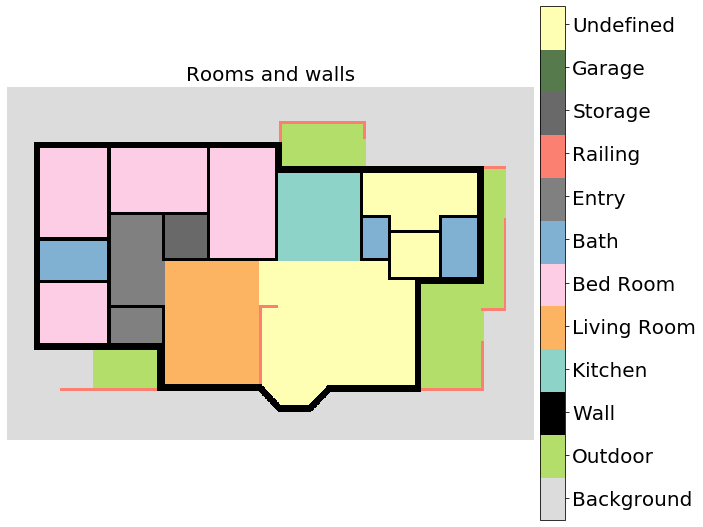

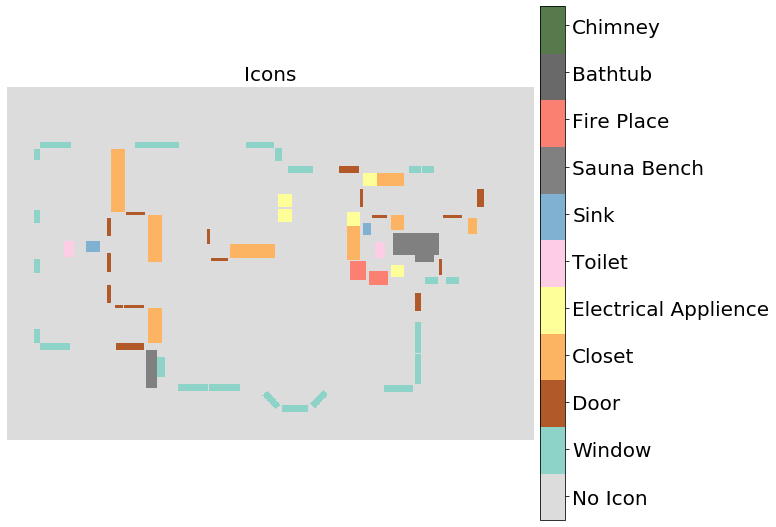

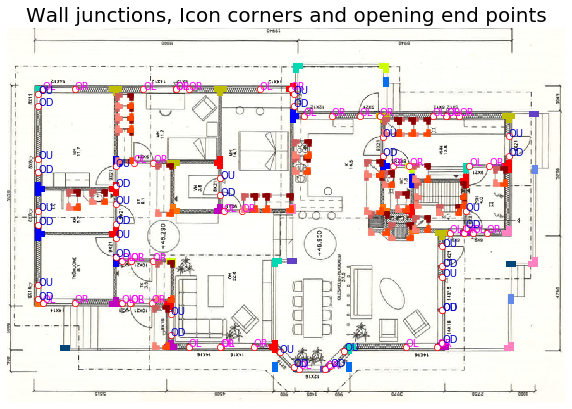

In [29]:
label_np = label.data.numpy()[0]
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Rooms and walls', fontsize=20)
ax.axis('off')
n_rooms = 12
rseg = ax.imshow(label_np[0], cmap='rooms', vmin=0, vmax=n_rooms-0.1)
cbar = plt.colorbar(rseg, ticks=np.arange(n_rooms) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(room_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Icons', fontsize=20)
ax.axis('off')
n_icons = 11
iseg = ax.imshow(label_np[1], cmap='icons', vmin=0, vmax=n_icons-0.1)
cbar = plt.colorbar(iseg, ticks=np.arange(n_icons) + 0.5, fraction=0.046, pad=0.01)
cbar.ax.set_yticklabels(icon_classes, fontsize=20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
plt.title('Wall junctions, Icon corners and opening end points', fontsize=20)
ax.axis('off')
ax.imshow(np_img)
h, w, _ = np_img.shape
draw_junction_from_dict(junctions, w, h, size=0.3, fontsize=10)
plt.show()

In [30]:
import copy
import cv2
x = copy.copy(label_np[0])
x[label_np[0] != 1] = 0 

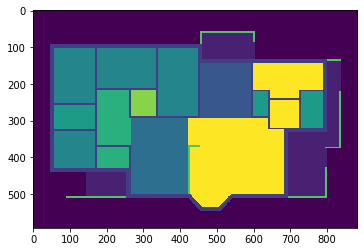

In [31]:
plt.imshow(label_np[0])

In [32]:
label_np[0].shape

(592, 883)

In [33]:
yimg = x.astype(np.uint8)

In [34]:
contours, hierarchy = cv2.findContours(yimg.copy(),\
                                       cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

Wall time: 156 ms


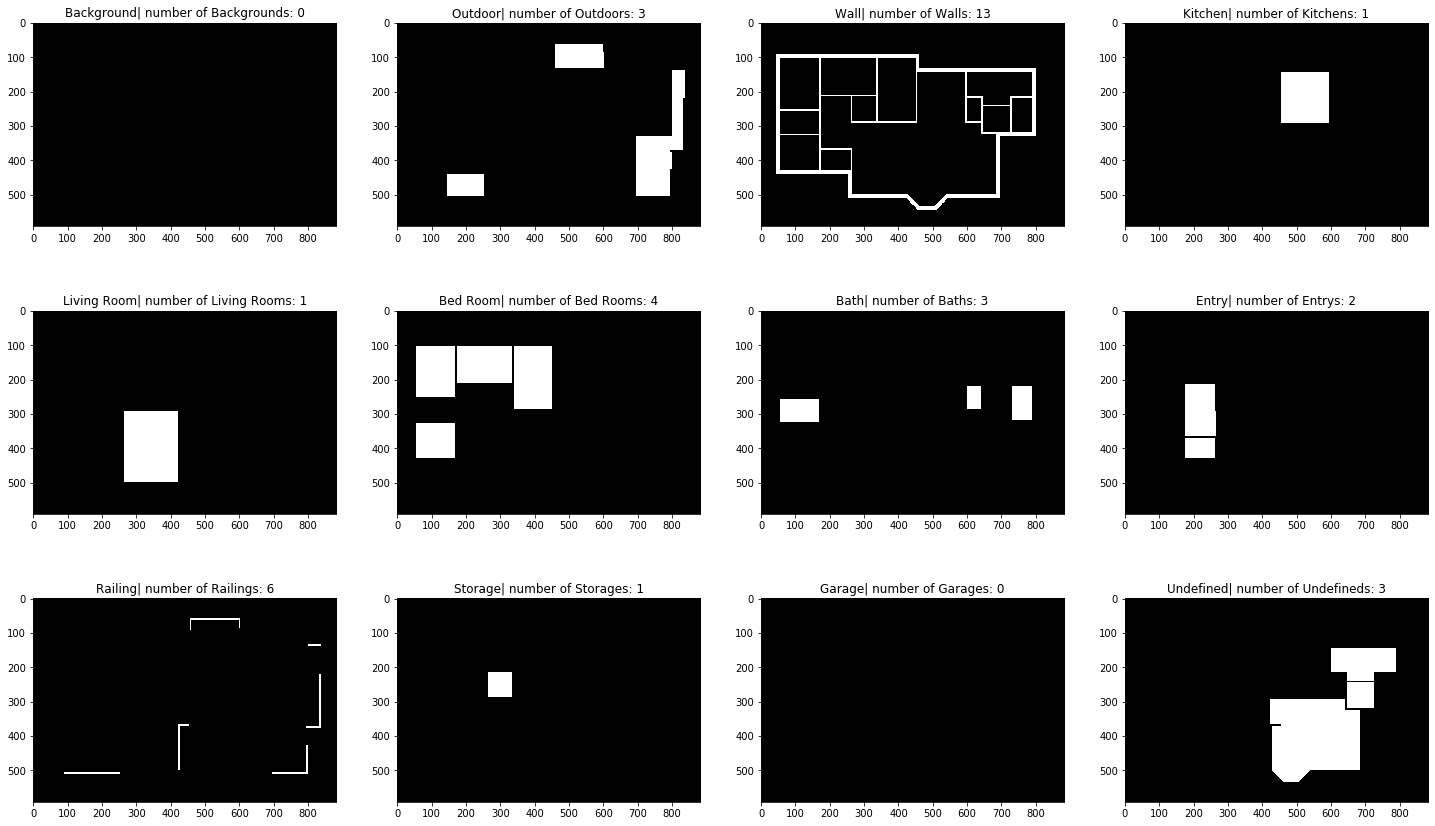

In [35]:
%%time
j = 0
k = 0 
fig,axes = plt.subplots(3,4,figsize=(25,15))
for i in range(12):
    if i % 4 ==0 and i !=0:
        j += 1
    if k == 4:
        k = 0 
    x = copy.copy(label_np[0])
    x[label_np[0] != i] = 0 
    x = x.astype(np.uint8)
    contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    axes[j][k].imshow(x,cmap="gray")
    axes[j][k].set_title(room_classes[i]+"| number of "+room_classes[i] + "s: "+ str(len(contours)))
    k+=1

    
    

Wall time: 225 ms


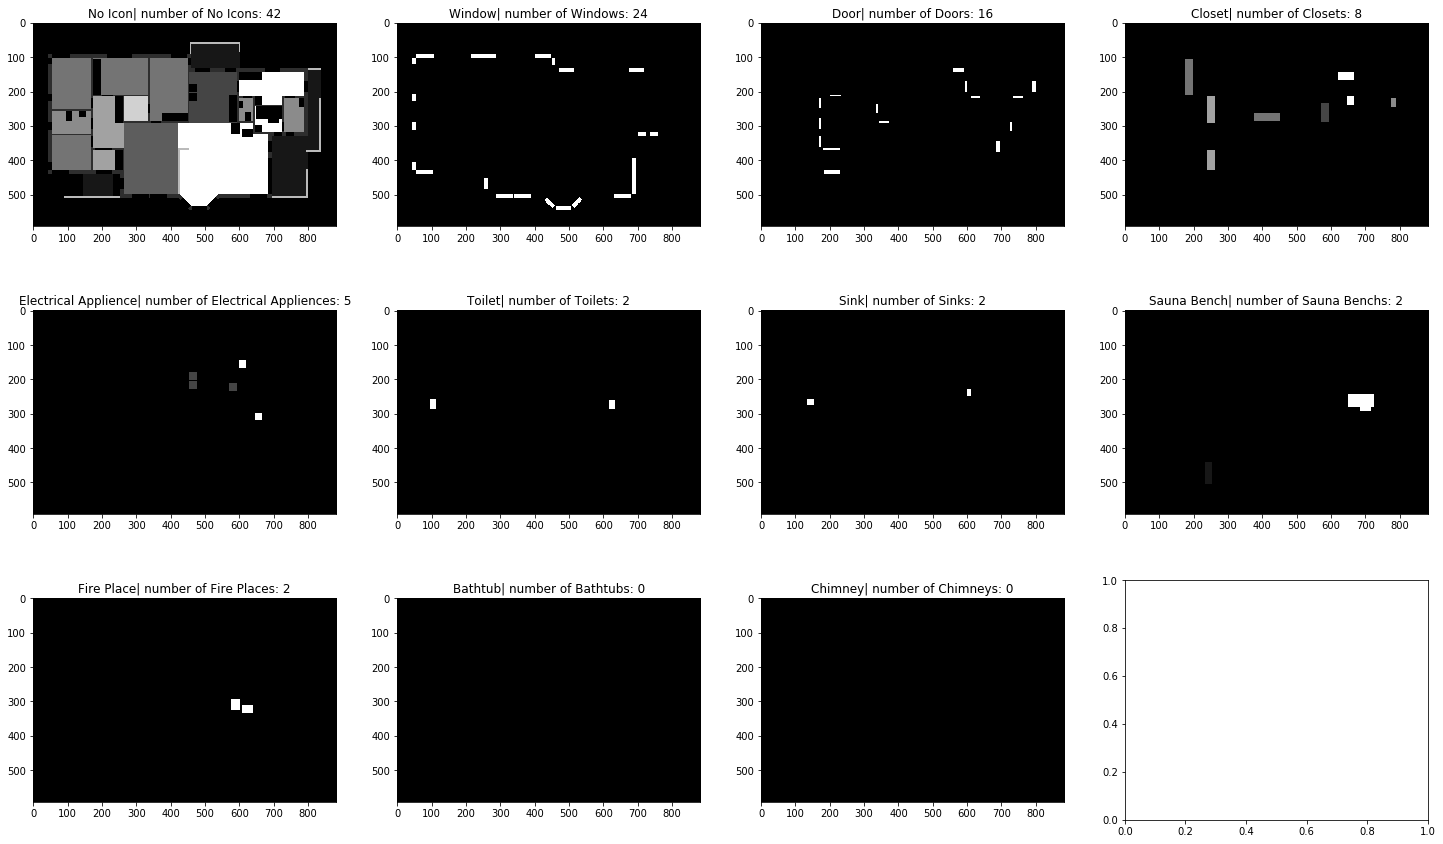

In [36]:
%%time
j = 0
k = 0 
fig,axes = plt.subplots(3,4,figsize=(25,15))
for i in range(11):
    if i % 4 ==0 and i !=0:
        j += 1
    if k == 4:
        k = 0 
    x = copy.copy(label_np[0])
    x[label_np[1] != i] = 0 
    x = x.astype(np.uint8)
    contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    axes[j][k].imshow(x,cmap="gray")
    axes[j][k].set_title(icon_classes[i]+"| number of "+icon_classes[i] + "s: "+ str(len(contours)))

    k+=1



In [24]:
from collections import defaultdict
import pickle
val_room_dict = defaultdict(int)

normal_set = FloorplanSVG(data_folder, 'val.txt', format='txt', original_size=True)
data_loader = DataLoader(normal_set, batch_size=1, num_workers=0)

for t,val in enumerate(data_loader):
    label_np = val['label'].data.numpy()[0][0]
    for i in range(12):
        x = copy.copy(label_np)
        x[label_np != i] = 0 
        x = x.astype(np.uint8)
        contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        val_room_dict[i]+=len(contours)
    

pkl_path = './EDA_results/val_rooms.pkl'
with open(pkl_path, 'wb') as pkl_file:
    pickle.dump(val_room_dict, pkl_file)



In [ ]:
val_room_dict

In [ ]:
val_icon_dict = defaultdict(int)
start = time.time()
for t,val in enumerate(data_loader):
    label_np = val['label'].data.numpy()[0][1]
    for i in range(11):
        x = copy.copy(label_np)
        x[label_np != i] = 0 
        x = x.astype(np.uint8)
        contours, _ = cv2.findContours(x,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        val_icon_dict[i]+=len(contours)
    
    if t%100 == 0:
        print(t,'finished', time.time() - start)


import pickle
pkl_path = './EDA_results/val_icons.pkl'
with open(pkl_path, 'wb') as pkl_file:
    pickle.dump(val_icon_dict, pkl_file)

In [ ]:
val_icon_dic